In [1]:
from rev import RevViT
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.amp import GradScaler

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  NVIDIA RTX A3000 Laptop GPU


In [3]:
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        ),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        ),
    ]
)

In [4]:
# Parameters
batch_size = 128 
embed_dim = 128
depth = 6
n_head = 8
epochs = 100
lr = 1e-3
patch_size = (4,4)
image_size = (32,32)
num_classes = 10
amp = False


In [5]:
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

In [6]:
# del model
torch.cuda.empty_cache()

In [7]:
num_patches = (image_size[0] // patch_size[0]) * (
            image_size[1] // patch_size[1]
        )
num_patches

64

In [8]:
rev_arch = RevViT

model = rev_arch(
    embed_dim=embed_dim,
    n_head=n_head,
    depth=depth,
    patch_size=patch_size,
    image_size=image_size,
    num_classes=num_classes,
    enable_amp=amp,
)

In [9]:
model

RevViT(
  (layers): ModuleList(
    (0-5): 6 x ReversibleBlock(
      (F): AttentionSubBlock(
        (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
      )
      (G): MLPSubblock(
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
      )
    )
  )
  (patch_embed): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
  (head): Linear(in_features=256, out_features=10, bias=True)
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
)

In [10]:
model = model.to(device)

model.no_custom_backward = False
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
scaler = GradScaler()

In [11]:
# Get model parameter count
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params:,}")

Total Parameters: 1,207,178


In [12]:
# Estimate model size (assuming float32 parameters, 4 bytes each)
model_size_mb = (total_params * 4) / (1024 * 1024)
print(f"Model Size: {model_size_mb:.2f} MB")

Model Size: 4.61 MB


In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
# Training
from tqdm import tqdm
def train(epoch):
    print("\nTraining Epoch: %d" % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
        # We do not need to specify AMP autocast in forward pass here since
        # that is taken care of already in the forward of individual modules.
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # standard pytorch AMP training setup
        # scaler also works without amp training.
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(f"Training Accuracy:{100.*correct/total: 0.2f}")
    print(f"Training Loss:{train_loss/(batch_idx+1): 0.3f}")
    return 100.0 * correct / total, train_loss / (batch_idx + 1)


def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    print("\nTesting Epoch: %d" % epoch)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print(f"Test Accuracy:{100.*correct/total: 0.2f}")
        print(f"Test Loss:{test_loss/(batch_idx+1): 0.3f}")
        return 100.0 * correct / total, test_loss / (batch_idx + 1)

In [15]:
import random

import numpy as np

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [16]:
from thop import profile
dummy_input = torch.randn(1, 3, 32, 32).to(device)
flops, _ = profile(model, inputs=(dummy_input,), verbose=False)
print(f"FLOPs per inference step: {flops / 1e9:.2f} GFLOPs")

FLOPs per inference step: 0.05 GFLOPs


In [17]:
import time
train_accs = []
test_accs = []

# Set up CUDA memory tracking
torch.cuda.reset_peak_memory_stats(device)  # Reset memory tracking
start_time = time.time()
for epoch in range(epochs):
    epoch_start = time.time()
    # Track peak memory usage
    torch.cuda.memory_allocated(device)  # Ensure PyTorch updates memory usage tracking
    torch.cuda.reset_peak_memory_stats(device)
    
    train_acc, train_loss = train(epoch)
    test_acc, test_loss = test(epoch)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    epoch_time = time.time() - epoch_start
    print(f"Time taken for epoch {epoch+1}: {epoch_time:.2f} seconds")
    # Track peak GPU memory usage
    peak_memory = torch.cuda.max_memory_allocated(device) / (1024**3)  # Convert to GB
    print(f"Peak GPU memory usage: {peak_memory:.2f} GB")
    
    # TFLOPs estimation for each epoch
    input_resolution = 32  # CIFAR-10 image size
    flops_per_image = (2 * total_params * input_resolution * input_resolution) / 1e12  # Approx. FLOPs per image
    total_tflops = flops_per_image * len(trainloader.dataset)  # TFLOPs per epoch
    print(f"Estimated TFLOPs for epoch {epoch+1}: {total_tflops:.4f}")
    
    if (epoch+1)%5 == 0:
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, './ReVit/' + 'RevVIT_V1' + '_CIFAR10_checkpoint.pt')
        
# End timing after training
total_training_time = time.time() - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

# Save final model checkpoint
final_checkpoint_path = f'./ReVIT/{'RevVIT_V1'}_CIFAR10_final.pt'
torch.save({
    'epoch': epochs,
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'train_acc': train_accs,
    'test_acc': test_accs
}, final_checkpoint_path)

print(f"Final model saved at: {final_checkpoint_path}")



Training Epoch: 0


100%|██████████| 391/391 [00:36<00:00, 10.65it/s]


Training Accuracy: 35.55
Training Loss: 1.733

Testing Epoch: 0


100%|██████████| 79/79 [00:13<00:00,  6.00it/s]


Test Accuracy: 47.43
Test Loss: 1.451
Time taken for epoch 1: 49.92 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 1: 123.6150

Training Epoch: 1


100%|██████████| 391/391 [00:35<00:00, 10.96it/s]


Training Accuracy: 49.38
Training Loss: 1.389

Testing Epoch: 1


100%|██████████| 79/79 [00:13<00:00,  5.94it/s]


Test Accuracy: 52.66
Test Loss: 1.323
Time taken for epoch 2: 48.99 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 2: 123.6150

Training Epoch: 2


100%|██████████| 391/391 [00:34<00:00, 11.24it/s]


Training Accuracy: 55.61
Training Loss: 1.230

Testing Epoch: 2


100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Test Accuracy: 56.49
Test Loss: 1.187
Time taken for epoch 3: 47.54 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 3: 123.6150

Training Epoch: 3


100%|██████████| 391/391 [00:34<00:00, 11.37it/s]


Training Accuracy: 59.48
Training Loss: 1.126

Testing Epoch: 3


100%|██████████| 79/79 [00:12<00:00,  6.27it/s]


Test Accuracy: 62.70
Test Loss: 1.040
Time taken for epoch 4: 47.00 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 4: 123.6150

Training Epoch: 4


100%|██████████| 391/391 [00:34<00:00, 11.24it/s]


Training Accuracy: 62.40
Training Loss: 1.050

Testing Epoch: 4


100%|██████████| 79/79 [00:12<00:00,  6.27it/s]


Test Accuracy: 62.28
Test Loss: 1.048
Time taken for epoch 5: 47.40 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 5: 123.6150

Training Epoch: 5


100%|██████████| 391/391 [00:34<00:00, 11.19it/s]


Training Accuracy: 65.10
Training Loss: 0.981

Testing Epoch: 5


100%|██████████| 79/79 [00:12<00:00,  6.16it/s]


Test Accuracy: 65.15
Test Loss: 0.982
Time taken for epoch 6: 47.77 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 6: 123.6150

Training Epoch: 6


100%|██████████| 391/391 [00:34<00:00, 11.33it/s]


Training Accuracy: 66.89
Training Loss: 0.927

Testing Epoch: 6


100%|██████████| 79/79 [00:12<00:00,  6.24it/s]


Test Accuracy: 67.77
Test Loss: 0.899
Time taken for epoch 7: 47.16 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 7: 123.6150

Training Epoch: 7


100%|██████████| 391/391 [00:34<00:00, 11.30it/s]


Training Accuracy: 68.64
Training Loss: 0.885

Testing Epoch: 7


100%|██████████| 79/79 [00:12<00:00,  6.29it/s]


Test Accuracy: 68.63
Test Loss: 0.897
Time taken for epoch 8: 47.17 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 8: 123.6150

Training Epoch: 8


100%|██████████| 391/391 [00:35<00:00, 11.09it/s]


Training Accuracy: 69.95
Training Loss: 0.842

Testing Epoch: 8


100%|██████████| 79/79 [00:13<00:00,  5.73it/s]


Test Accuracy: 70.71
Test Loss: 0.830
Time taken for epoch 9: 49.05 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 9: 123.6150

Training Epoch: 9


100%|██████████| 391/391 [00:35<00:00, 10.87it/s]


Training Accuracy: 71.44
Training Loss: 0.804

Testing Epoch: 9


100%|██████████| 79/79 [00:14<00:00,  5.44it/s]


Test Accuracy: 71.34
Test Loss: 0.816
Time taken for epoch 10: 50.51 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 10: 123.6150

Training Epoch: 10


100%|██████████| 391/391 [00:35<00:00, 11.04it/s]


Training Accuracy: 72.68
Training Loss: 0.774

Testing Epoch: 10


100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Test Accuracy: 72.23
Test Loss: 0.787
Time taken for epoch 11: 48.15 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 11: 123.6150

Training Epoch: 11


100%|██████████| 391/391 [00:35<00:00, 10.96it/s]


Training Accuracy: 73.50
Training Loss: 0.743

Testing Epoch: 11


100%|██████████| 79/79 [00:12<00:00,  6.10it/s]


Test Accuracy: 72.79
Test Loss: 0.759
Time taken for epoch 12: 48.62 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 12: 123.6150

Training Epoch: 12


100%|██████████| 391/391 [00:34<00:00, 11.31it/s]


Training Accuracy: 74.66
Training Loss: 0.718

Testing Epoch: 12


100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Test Accuracy: 74.06
Test Loss: 0.744
Time taken for epoch 13: 47.32 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 13: 123.6150

Training Epoch: 13


100%|██████████| 391/391 [00:34<00:00, 11.27it/s]


Training Accuracy: 75.31
Training Loss: 0.693

Testing Epoch: 13


100%|██████████| 79/79 [00:13<00:00,  6.02it/s]


Test Accuracy: 72.90
Test Loss: 0.757
Time taken for epoch 14: 47.82 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 14: 123.6150

Training Epoch: 14


100%|██████████| 391/391 [00:34<00:00, 11.18it/s]


Training Accuracy: 76.38
Training Loss: 0.666

Testing Epoch: 14


100%|██████████| 79/79 [00:13<00:00,  6.07it/s]


Test Accuracy: 74.92
Test Loss: 0.715
Time taken for epoch 15: 48.00 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 15: 123.6150

Training Epoch: 15


100%|██████████| 391/391 [00:34<00:00, 11.26it/s]


Training Accuracy: 77.13
Training Loss: 0.646

Testing Epoch: 15


100%|██████████| 79/79 [00:12<00:00,  6.11it/s]


Test Accuracy: 76.01
Test Loss: 0.692
Time taken for epoch 16: 47.67 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 16: 123.6150

Training Epoch: 16


100%|██████████| 391/391 [00:34<00:00, 11.27it/s]


Training Accuracy: 78.05
Training Loss: 0.623

Testing Epoch: 16


100%|██████████| 79/79 [00:12<00:00,  6.12it/s]


Test Accuracy: 75.66
Test Loss: 0.685
Time taken for epoch 17: 47.61 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 17: 123.6150

Training Epoch: 17


100%|██████████| 391/391 [00:34<00:00, 11.28it/s]


Training Accuracy: 78.38
Training Loss: 0.607

Testing Epoch: 17


100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Test Accuracy: 76.88
Test Loss: 0.665
Time taken for epoch 18: 47.40 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 18: 123.6150

Training Epoch: 18


100%|██████████| 391/391 [00:34<00:00, 11.30it/s]


Training Accuracy: 79.27
Training Loss: 0.587

Testing Epoch: 18


100%|██████████| 79/79 [00:12<00:00,  6.11it/s]


Test Accuracy: 76.91
Test Loss: 0.654
Time taken for epoch 19: 47.55 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 19: 123.6150

Training Epoch: 19


100%|██████████| 391/391 [00:34<00:00, 11.29it/s]


Training Accuracy: 79.79
Training Loss: 0.570

Testing Epoch: 19


100%|██████████| 79/79 [00:12<00:00,  6.17it/s]


Test Accuracy: 76.59
Test Loss: 0.657
Time taken for epoch 20: 47.44 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 20: 123.6150

Training Epoch: 20


100%|██████████| 391/391 [00:34<00:00, 11.30it/s]


Training Accuracy: 80.42
Training Loss: 0.551

Testing Epoch: 20


100%|██████████| 79/79 [00:12<00:00,  6.11it/s]


Test Accuracy: 77.62
Test Loss: 0.656
Time taken for epoch 21: 47.54 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 21: 123.6150

Training Epoch: 21


100%|██████████| 391/391 [00:34<00:00, 11.31it/s]


Training Accuracy: 81.09
Training Loss: 0.534

Testing Epoch: 21


100%|██████████| 79/79 [00:12<00:00,  6.16it/s]


Test Accuracy: 77.40
Test Loss: 0.652
Time taken for epoch 22: 47.41 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 22: 123.6150

Training Epoch: 22


100%|██████████| 391/391 [00:34<00:00, 11.31it/s]


Training Accuracy: 81.30
Training Loss: 0.527

Testing Epoch: 22


100%|██████████| 79/79 [00:12<00:00,  6.29it/s]


Test Accuracy: 77.91
Test Loss: 0.642
Time taken for epoch 23: 47.15 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 23: 123.6150

Training Epoch: 23


100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


Training Accuracy: 82.02
Training Loss: 0.501

Testing Epoch: 23


100%|██████████| 79/79 [00:12<00:00,  6.22it/s]


Test Accuracy: 78.86
Test Loss: 0.612
Time taken for epoch 24: 47.59 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 24: 123.6150

Training Epoch: 24


100%|██████████| 391/391 [00:34<00:00, 11.28it/s]


Training Accuracy: 82.78
Training Loss: 0.485

Testing Epoch: 24


100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Test Accuracy: 77.64
Test Loss: 0.654
Time taken for epoch 25: 47.39 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 25: 123.6150

Training Epoch: 25


100%|██████████| 391/391 [00:34<00:00, 11.32it/s]


Training Accuracy: 83.00
Training Loss: 0.474

Testing Epoch: 25


100%|██████████| 79/79 [00:12<00:00,  6.17it/s]


Test Accuracy: 77.87
Test Loss: 0.638
Time taken for epoch 26: 47.34 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 26: 123.6150

Training Epoch: 26


100%|██████████| 391/391 [00:34<00:00, 11.30it/s]


Training Accuracy: 83.31
Training Loss: 0.466

Testing Epoch: 26


100%|██████████| 79/79 [00:12<00:00,  6.19it/s]


Test Accuracy: 79.61
Test Loss: 0.615
Time taken for epoch 27: 47.37 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 27: 123.6150

Training Epoch: 27


100%|██████████| 391/391 [00:34<00:00, 11.30it/s]


Training Accuracy: 84.30
Training Loss: 0.442

Testing Epoch: 27


100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Test Accuracy: 79.01
Test Loss: 0.623
Time taken for epoch 28: 47.37 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 28: 123.6150

Training Epoch: 28


100%|██████████| 391/391 [00:34<00:00, 11.29it/s]


Training Accuracy: 84.56
Training Loss: 0.433

Testing Epoch: 28


100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Test Accuracy: 79.15
Test Loss: 0.626
Time taken for epoch 29: 47.40 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 29: 123.6150

Training Epoch: 29


100%|██████████| 391/391 [00:34<00:00, 11.28it/s]


Training Accuracy: 85.02
Training Loss: 0.415

Testing Epoch: 29


100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


Test Accuracy: 79.76
Test Loss: 0.615
Time taken for epoch 30: 47.39 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 30: 123.6150

Training Epoch: 30


100%|██████████| 391/391 [00:34<00:00, 11.28it/s]


Training Accuracy: 85.68
Training Loss: 0.407

Testing Epoch: 30


100%|██████████| 79/79 [00:12<00:00,  6.14it/s]


Test Accuracy: 77.85
Test Loss: 0.651
Time taken for epoch 31: 47.54 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 31: 123.6150

Training Epoch: 31


100%|██████████| 391/391 [00:34<00:00, 11.30it/s]


Training Accuracy: 85.66
Training Loss: 0.396

Testing Epoch: 31


100%|██████████| 79/79 [00:12<00:00,  6.19it/s]


Test Accuracy: 78.92
Test Loss: 0.634
Time taken for epoch 32: 47.40 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 32: 123.6150

Training Epoch: 32


100%|██████████| 391/391 [00:34<00:00, 11.17it/s]


Training Accuracy: 86.25
Training Loss: 0.381

Testing Epoch: 32


100%|██████████| 79/79 [00:12<00:00,  6.11it/s]


Test Accuracy: 80.15
Test Loss: 0.604
Time taken for epoch 33: 47.94 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 33: 123.6150

Training Epoch: 33


100%|██████████| 391/391 [00:34<00:00, 11.31it/s]


Training Accuracy: 86.80
Training Loss: 0.369

Testing Epoch: 33


100%|██████████| 79/79 [00:12<00:00,  6.14it/s]


Test Accuracy: 80.19
Test Loss: 0.611
Time taken for epoch 34: 47.43 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 34: 123.6150

Training Epoch: 34


100%|██████████| 391/391 [00:35<00:00, 11.17it/s]


Training Accuracy: 87.03
Training Loss: 0.360

Testing Epoch: 34


100%|██████████| 79/79 [00:14<00:00,  5.64it/s]


Test Accuracy: 78.64
Test Loss: 0.650
Time taken for epoch 35: 49.05 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 35: 123.6150

Training Epoch: 35


100%|██████████| 391/391 [00:35<00:00, 11.11it/s]


Training Accuracy: 87.62
Training Loss: 0.349

Testing Epoch: 35


100%|██████████| 79/79 [00:13<00:00,  5.95it/s]


Test Accuracy: 79.44
Test Loss: 0.628
Time taken for epoch 36: 48.48 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 36: 123.6150

Training Epoch: 36


100%|██████████| 391/391 [00:35<00:00, 11.16it/s]


Training Accuracy: 88.09
Training Loss: 0.333

Testing Epoch: 36


100%|██████████| 79/79 [00:13<00:00,  6.01it/s]


Test Accuracy: 80.27
Test Loss: 0.619
Time taken for epoch 37: 48.20 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 37: 123.6150

Training Epoch: 37


100%|██████████| 391/391 [00:34<00:00, 11.23it/s]


Training Accuracy: 88.38
Training Loss: 0.329

Testing Epoch: 37


100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


Test Accuracy: 79.18
Test Loss: 0.664
Time taken for epoch 38: 47.57 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 38: 123.6150

Training Epoch: 38


100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


Training Accuracy: 88.54
Training Loss: 0.317

Testing Epoch: 38


100%|██████████| 79/79 [00:12<00:00,  6.10it/s]


Test Accuracy: 80.09
Test Loss: 0.647
Time taken for epoch 39: 47.81 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 39: 123.6150

Training Epoch: 39


100%|██████████| 391/391 [00:34<00:00, 11.23it/s]


Training Accuracy: 89.01
Training Loss: 0.307

Testing Epoch: 39


100%|██████████| 79/79 [00:12<00:00,  6.14it/s]


Test Accuracy: 79.03
Test Loss: 0.683
Time taken for epoch 40: 47.70 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 40: 123.6150

Training Epoch: 40


100%|██████████| 391/391 [00:34<00:00, 11.23it/s]


Training Accuracy: 89.44
Training Loss: 0.295

Testing Epoch: 40


100%|██████████| 79/79 [00:12<00:00,  6.11it/s]


Test Accuracy: 79.94
Test Loss: 0.651
Time taken for epoch 41: 47.78 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 41: 123.6150

Training Epoch: 41


100%|██████████| 391/391 [00:34<00:00, 11.22it/s]


Training Accuracy: 89.52
Training Loss: 0.287

Testing Epoch: 41


100%|██████████| 79/79 [00:12<00:00,  6.11it/s]


Test Accuracy: 79.59
Test Loss: 0.682
Time taken for epoch 42: 47.77 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 42: 123.6150

Training Epoch: 42


100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


Training Accuracy: 89.74
Training Loss: 0.282

Testing Epoch: 42


100%|██████████| 79/79 [00:13<00:00,  6.05it/s]


Test Accuracy: 80.00
Test Loss: 0.676
Time taken for epoch 43: 47.94 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 43: 123.6150

Training Epoch: 43


100%|██████████| 391/391 [00:34<00:00, 11.26it/s]


Training Accuracy: 90.11
Training Loss: 0.274

Testing Epoch: 43


100%|██████████| 79/79 [00:12<00:00,  6.13it/s]


Test Accuracy: 79.97
Test Loss: 0.647
Time taken for epoch 44: 47.63 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 44: 123.6150

Training Epoch: 44


100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


Training Accuracy: 90.48
Training Loss: 0.260

Testing Epoch: 44


100%|██████████| 79/79 [00:12<00:00,  6.12it/s]


Test Accuracy: 79.35
Test Loss: 0.697
Time taken for epoch 45: 47.79 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 45: 123.6150

Training Epoch: 45


100%|██████████| 391/391 [00:34<00:00, 11.25it/s]


Training Accuracy: 90.73
Training Loss: 0.260

Testing Epoch: 45


100%|██████████| 79/79 [00:12<00:00,  6.10it/s]


Test Accuracy: 79.64
Test Loss: 0.697
Time taken for epoch 46: 47.73 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 46: 123.6150

Training Epoch: 46


100%|██████████| 391/391 [00:34<00:00, 11.26it/s]


Training Accuracy: 91.11
Training Loss: 0.244

Testing Epoch: 46


100%|██████████| 79/79 [00:12<00:00,  6.12it/s]


Test Accuracy: 79.52
Test Loss: 0.715
Time taken for epoch 47: 47.62 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 47: 123.6150

Training Epoch: 47


100%|██████████| 391/391 [00:34<00:00, 11.28it/s]


Training Accuracy: 91.02
Training Loss: 0.248

Testing Epoch: 47


100%|██████████| 79/79 [00:12<00:00,  6.11it/s]


Test Accuracy: 79.42
Test Loss: 0.683
Time taken for epoch 48: 47.61 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 48: 123.6150

Training Epoch: 48


100%|██████████| 391/391 [00:35<00:00, 11.16it/s]


Training Accuracy: 91.63
Training Loss: 0.234

Testing Epoch: 48


100%|██████████| 79/79 [00:13<00:00,  6.04it/s]


Test Accuracy: 79.83
Test Loss: 0.707
Time taken for epoch 49: 48.13 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 49: 123.6150

Training Epoch: 49


100%|██████████| 391/391 [00:34<00:00, 11.27it/s]


Training Accuracy: 91.97
Training Loss: 0.222

Testing Epoch: 49


100%|██████████| 79/79 [00:13<00:00,  6.04it/s]


Test Accuracy: 79.83
Test Loss: 0.720
Time taken for epoch 50: 47.80 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 50: 123.6150

Training Epoch: 50


100%|██████████| 391/391 [00:34<00:00, 11.18it/s]


Training Accuracy: 91.97
Training Loss: 0.223

Testing Epoch: 50


100%|██████████| 79/79 [00:13<00:00,  6.01it/s]


Test Accuracy: 78.95
Test Loss: 0.730
Time taken for epoch 51: 48.15 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 51: 123.6150

Training Epoch: 51


100%|██████████| 391/391 [00:34<00:00, 11.23it/s]


Training Accuracy: 92.05
Training Loss: 0.221

Testing Epoch: 51


100%|██████████| 79/79 [00:12<00:00,  6.10it/s]


Test Accuracy: 79.78
Test Loss: 0.710
Time taken for epoch 52: 47.78 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 52: 123.6150

Training Epoch: 52


100%|██████████| 391/391 [00:34<00:00, 11.22it/s]


Training Accuracy: 92.56
Training Loss: 0.209

Testing Epoch: 52


100%|██████████| 79/79 [00:13<00:00,  6.02it/s]


Test Accuracy: 80.29
Test Loss: 0.727
Time taken for epoch 53: 47.97 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 53: 123.6150

Training Epoch: 53


100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


Training Accuracy: 92.72
Training Loss: 0.205

Testing Epoch: 53


100%|██████████| 79/79 [00:12<00:00,  6.11it/s]


Test Accuracy: 79.27
Test Loss: 0.734
Time taken for epoch 54: 47.80 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 54: 123.6150

Training Epoch: 54


100%|██████████| 391/391 [00:34<00:00, 11.22it/s]


Training Accuracy: 92.82
Training Loss: 0.199

Testing Epoch: 54


100%|██████████| 79/79 [00:12<00:00,  6.08it/s]


Test Accuracy: 79.10
Test Loss: 0.760
Time taken for epoch 55: 47.83 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 55: 123.6150

Training Epoch: 55


100%|██████████| 391/391 [00:34<00:00, 11.25it/s]


Training Accuracy: 93.35
Training Loss: 0.187

Testing Epoch: 55


100%|██████████| 79/79 [00:12<00:00,  6.13it/s]


Test Accuracy: 79.28
Test Loss: 0.761
Time taken for epoch 56: 47.68 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 56: 123.6150

Training Epoch: 56


100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


Training Accuracy: 93.34
Training Loss: 0.188

Testing Epoch: 56


100%|██████████| 79/79 [00:12<00:00,  6.13it/s]


Test Accuracy: 79.35
Test Loss: 0.774
Time taken for epoch 57: 47.77 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 57: 123.6150

Training Epoch: 57


100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


Training Accuracy: 93.32
Training Loss: 0.184

Testing Epoch: 57


100%|██████████| 79/79 [00:12<00:00,  6.11it/s]


Test Accuracy: 80.45
Test Loss: 0.752
Time taken for epoch 58: 47.80 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 58: 123.6150

Training Epoch: 58


100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


Training Accuracy: 93.48
Training Loss: 0.178

Testing Epoch: 58


100%|██████████| 79/79 [00:13<00:00,  6.04it/s]


Test Accuracy: 79.88
Test Loss: 0.772
Time taken for epoch 59: 47.99 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 59: 123.6150

Training Epoch: 59


100%|██████████| 391/391 [00:35<00:00, 11.16it/s]


Training Accuracy: 93.59
Training Loss: 0.179

Testing Epoch: 59


100%|██████████| 79/79 [00:12<00:00,  6.10it/s]


Test Accuracy: 79.46
Test Loss: 0.769
Time taken for epoch 60: 48.00 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 60: 123.6150

Training Epoch: 60


100%|██████████| 391/391 [00:34<00:00, 11.24it/s]


Training Accuracy: 93.72
Training Loss: 0.172

Testing Epoch: 60


100%|██████████| 79/79 [00:13<00:00,  6.04it/s]


Test Accuracy: 79.76
Test Loss: 0.766
Time taken for epoch 61: 47.89 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 61: 123.6150

Training Epoch: 61


100%|██████████| 391/391 [00:34<00:00, 11.17it/s]


Training Accuracy: 93.93
Training Loss: 0.167

Testing Epoch: 61


100%|██████████| 79/79 [00:12<00:00,  6.09it/s]


Test Accuracy: 80.07
Test Loss: 0.806
Time taken for epoch 62: 47.98 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 62: 123.6150

Training Epoch: 62


100%|██████████| 391/391 [00:34<00:00, 11.25it/s]


Training Accuracy: 94.02
Training Loss: 0.164

Testing Epoch: 62


100%|██████████| 79/79 [00:13<00:00,  6.06it/s]


Test Accuracy: 78.85
Test Loss: 0.851
Time taken for epoch 63: 47.80 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 63: 123.6150

Training Epoch: 63


100%|██████████| 391/391 [00:34<00:00, 11.22it/s]


Training Accuracy: 94.34
Training Loss: 0.159

Testing Epoch: 63


100%|██████████| 79/79 [00:12<00:00,  6.11it/s]


Test Accuracy: 79.84
Test Loss: 0.805
Time taken for epoch 64: 47.78 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 64: 123.6150

Training Epoch: 64


100%|██████████| 391/391 [00:34<00:00, 11.19it/s]


Training Accuracy: 94.44
Training Loss: 0.154

Testing Epoch: 64


100%|██████████| 79/79 [00:13<00:00,  6.05it/s]


Test Accuracy: 80.03
Test Loss: 0.792
Time taken for epoch 65: 47.98 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 65: 123.6150

Training Epoch: 65


100%|██████████| 391/391 [00:34<00:00, 11.24it/s]


Training Accuracy: 94.61
Training Loss: 0.153

Testing Epoch: 65


100%|██████████| 79/79 [00:13<00:00,  6.03it/s]


Test Accuracy: 80.17
Test Loss: 0.788
Time taken for epoch 66: 47.89 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 66: 123.6150

Training Epoch: 66


100%|██████████| 391/391 [00:34<00:00, 11.20it/s]


Training Accuracy: 94.83
Training Loss: 0.145

Testing Epoch: 66


100%|██████████| 79/79 [00:12<00:00,  6.12it/s]


Test Accuracy: 79.98
Test Loss: 0.823
Time taken for epoch 67: 47.83 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 67: 123.6150

Training Epoch: 67


100%|██████████| 391/391 [00:34<00:00, 11.19it/s]


Training Accuracy: 94.70
Training Loss: 0.148

Testing Epoch: 67


100%|██████████| 79/79 [00:12<00:00,  6.15it/s]


Test Accuracy: 80.03
Test Loss: 0.832
Time taken for epoch 68: 47.79 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 68: 123.6150

Training Epoch: 68


100%|██████████| 391/391 [00:34<00:00, 11.22it/s]


Training Accuracy: 94.89
Training Loss: 0.142

Testing Epoch: 68


100%|██████████| 79/79 [00:12<00:00,  6.11it/s]


Test Accuracy: 79.88
Test Loss: 0.830
Time taken for epoch 69: 47.79 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 69: 123.6150

Training Epoch: 69


100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


Training Accuracy: 94.90
Training Loss: 0.142

Testing Epoch: 69


100%|██████████| 79/79 [00:13<00:00,  6.03it/s]


Test Accuracy: 79.58
Test Loss: 0.857
Time taken for epoch 70: 47.99 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 70: 123.6150

Training Epoch: 70


100%|██████████| 391/391 [00:34<00:00, 11.23it/s]


Training Accuracy: 95.02
Training Loss: 0.137

Testing Epoch: 70


100%|██████████| 79/79 [00:13<00:00,  6.03it/s]


Test Accuracy: 79.76
Test Loss: 0.832
Time taken for epoch 71: 47.94 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 71: 123.6150

Training Epoch: 71


100%|██████████| 391/391 [00:35<00:00, 11.03it/s]


Training Accuracy: 95.27
Training Loss: 0.135

Testing Epoch: 71


100%|██████████| 79/79 [00:13<00:00,  6.04it/s]


Test Accuracy: 80.07
Test Loss: 0.845
Time taken for epoch 72: 48.55 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 72: 123.6150

Training Epoch: 72


100%|██████████| 391/391 [00:34<00:00, 11.20it/s]


Training Accuracy: 95.32
Training Loss: 0.132

Testing Epoch: 72


100%|██████████| 79/79 [00:13<00:00,  6.01it/s]


Test Accuracy: 80.49
Test Loss: 0.814
Time taken for epoch 73: 48.04 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 73: 123.6150

Training Epoch: 73


100%|██████████| 391/391 [00:35<00:00, 11.14it/s]


Training Accuracy: 94.97
Training Loss: 0.138

Testing Epoch: 73


100%|██████████| 79/79 [00:13<00:00,  6.05it/s]


Test Accuracy: 80.00
Test Loss: 0.826
Time taken for epoch 74: 48.15 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 74: 123.6150

Training Epoch: 74


100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


Training Accuracy: 95.47
Training Loss: 0.129

Testing Epoch: 74


100%|██████████| 79/79 [00:13<00:00,  6.02it/s]


Test Accuracy: 79.55
Test Loss: 0.810
Time taken for epoch 75: 47.98 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 75: 123.6150

Training Epoch: 75


100%|██████████| 391/391 [00:34<00:00, 11.20it/s]


Training Accuracy: 95.54
Training Loss: 0.125

Testing Epoch: 75


100%|██████████| 79/79 [00:13<00:00,  6.06it/s]


Test Accuracy: 79.65
Test Loss: 0.864
Time taken for epoch 76: 47.94 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 76: 123.6150

Training Epoch: 76


100%|██████████| 391/391 [00:34<00:00, 11.28it/s]


Training Accuracy: 95.66
Training Loss: 0.122

Testing Epoch: 76


100%|██████████| 79/79 [00:13<00:00,  6.04it/s]


Test Accuracy: 79.21
Test Loss: 0.854
Time taken for epoch 77: 47.75 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 77: 123.6150

Training Epoch: 77


100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


Training Accuracy: 95.45
Training Loss: 0.127

Testing Epoch: 77


100%|██████████| 79/79 [00:12<00:00,  6.12it/s]


Test Accuracy: 79.41
Test Loss: 0.850
Time taken for epoch 78: 47.80 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 78: 123.6150

Training Epoch: 78


100%|██████████| 391/391 [00:34<00:00, 11.20it/s]


Training Accuracy: 95.70
Training Loss: 0.119

Testing Epoch: 78


100%|██████████| 79/79 [00:12<00:00,  6.12it/s]


Test Accuracy: 80.38
Test Loss: 0.865
Time taken for epoch 79: 47.81 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 79: 123.6150

Training Epoch: 79


100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


Training Accuracy: 95.61
Training Loss: 0.122

Testing Epoch: 79


100%|██████████| 79/79 [00:12<00:00,  6.14it/s]


Test Accuracy: 79.47
Test Loss: 0.904
Time taken for epoch 80: 47.76 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 80: 123.6150

Training Epoch: 80


100%|██████████| 391/391 [00:34<00:00, 11.24it/s]


Training Accuracy: 95.85
Training Loss: 0.115

Testing Epoch: 80


100%|██████████| 79/79 [00:12<00:00,  6.09it/s]


Test Accuracy: 79.15
Test Loss: 0.939
Time taken for epoch 81: 47.77 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 81: 123.6150

Training Epoch: 81


100%|██████████| 391/391 [00:34<00:00, 11.30it/s]


Training Accuracy: 95.84
Training Loss: 0.118

Testing Epoch: 81


100%|██████████| 79/79 [00:12<00:00,  6.11it/s]


Test Accuracy: 80.11
Test Loss: 0.889
Time taken for epoch 82: 47.55 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 82: 123.6150

Training Epoch: 82


100%|██████████| 391/391 [00:35<00:00, 11.13it/s]


Training Accuracy: 96.09
Training Loss: 0.109

Testing Epoch: 82


100%|██████████| 79/79 [00:13<00:00,  6.04it/s]


Test Accuracy: 79.83
Test Loss: 0.875
Time taken for epoch 83: 48.21 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 83: 123.6150

Training Epoch: 83


100%|██████████| 391/391 [00:35<00:00, 11.15it/s]


Training Accuracy: 95.97
Training Loss: 0.111

Testing Epoch: 83


100%|██████████| 79/79 [00:13<00:00,  6.03it/s]


Test Accuracy: 79.07
Test Loss: 0.952
Time taken for epoch 84: 48.16 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 84: 123.6150

Training Epoch: 84


100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


Training Accuracy: 95.87
Training Loss: 0.117

Testing Epoch: 84


100%|██████████| 79/79 [00:13<00:00,  6.03it/s]


Test Accuracy: 79.80
Test Loss: 0.879
Time taken for epoch 85: 48.00 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 85: 123.6150

Training Epoch: 85


100%|██████████| 391/391 [00:34<00:00, 11.18it/s]


Training Accuracy: 96.20
Training Loss: 0.105

Testing Epoch: 85


100%|██████████| 79/79 [00:13<00:00,  6.02it/s]


Test Accuracy: 78.97
Test Loss: 0.935
Time taken for epoch 86: 48.11 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 86: 123.6150

Training Epoch: 86


100%|██████████| 391/391 [00:34<00:00, 11.20it/s]


Training Accuracy: 96.20
Training Loss: 0.106

Testing Epoch: 86


100%|██████████| 79/79 [00:13<00:00,  6.05it/s]


Test Accuracy: 79.59
Test Loss: 0.942
Time taken for epoch 87: 47.99 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 87: 123.6150

Training Epoch: 87


100%|██████████| 391/391 [00:34<00:00, 11.20it/s]


Training Accuracy: 96.35
Training Loss: 0.103

Testing Epoch: 87


100%|██████████| 79/79 [00:12<00:00,  6.12it/s]


Test Accuracy: 79.01
Test Loss: 0.951
Time taken for epoch 88: 47.82 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 88: 123.6150

Training Epoch: 88


100%|██████████| 391/391 [00:34<00:00, 11.26it/s]


Training Accuracy: 96.26
Training Loss: 0.105

Testing Epoch: 88


100%|██████████| 79/79 [00:13<00:00,  6.03it/s]


Test Accuracy: 79.70
Test Loss: 0.899
Time taken for epoch 89: 47.82 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 89: 123.6150

Training Epoch: 89


100%|██████████| 391/391 [00:34<00:00, 11.22it/s]


Training Accuracy: 96.50
Training Loss: 0.100

Testing Epoch: 89


100%|██████████| 79/79 [00:13<00:00,  6.02it/s]


Test Accuracy: 79.95
Test Loss: 0.907
Time taken for epoch 90: 47.96 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 90: 123.6150

Training Epoch: 90


100%|██████████| 391/391 [00:34<00:00, 11.18it/s]


Training Accuracy: 96.32
Training Loss: 0.103

Testing Epoch: 90


100%|██████████| 79/79 [00:12<00:00,  6.11it/s]


Test Accuracy: 79.90
Test Loss: 0.912
Time taken for epoch 91: 47.89 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 91: 123.6150

Training Epoch: 91


100%|██████████| 391/391 [00:34<00:00, 11.20it/s]


Training Accuracy: 96.61
Training Loss: 0.096

Testing Epoch: 91


100%|██████████| 79/79 [00:12<00:00,  6.13it/s]


Test Accuracy: 80.02
Test Loss: 0.920
Time taken for epoch 92: 47.80 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 92: 123.6150

Training Epoch: 92


100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


Training Accuracy: 96.52
Training Loss: 0.098

Testing Epoch: 92


100%|██████████| 79/79 [00:13<00:00,  6.03it/s]


Test Accuracy: 79.53
Test Loss: 0.989
Time taken for epoch 93: 47.97 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 93: 123.6150

Training Epoch: 93


100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


Training Accuracy: 96.34
Training Loss: 0.102

Testing Epoch: 93


100%|██████████| 79/79 [00:12<00:00,  6.11it/s]


Test Accuracy: 79.34
Test Loss: 0.937
Time taken for epoch 94: 47.80 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 94: 123.6150

Training Epoch: 94


100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


Training Accuracy: 96.65
Training Loss: 0.097

Testing Epoch: 94


100%|██████████| 79/79 [00:13<00:00,  6.04it/s]


Test Accuracy: 80.13
Test Loss: 0.910
Time taken for epoch 95: 47.97 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 95: 123.6150

Training Epoch: 95


100%|██████████| 391/391 [00:34<00:00, 11.19it/s]


Training Accuracy: 96.72
Training Loss: 0.094

Testing Epoch: 95


100%|██████████| 79/79 [00:13<00:00,  5.98it/s]


Test Accuracy: 79.33
Test Loss: 0.945
Time taken for epoch 96: 48.15 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 96: 123.6150

Training Epoch: 96


100%|██████████| 391/391 [00:34<00:00, 11.22it/s]


Training Accuracy: 96.78
Training Loss: 0.093

Testing Epoch: 96


100%|██████████| 79/79 [00:12<00:00,  6.10it/s]


Test Accuracy: 78.91
Test Loss: 0.971
Time taken for epoch 97: 47.78 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 97: 123.6150

Training Epoch: 97


100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


Training Accuracy: 96.76
Training Loss: 0.092

Testing Epoch: 97


100%|██████████| 79/79 [00:12<00:00,  6.11it/s]


Test Accuracy: 80.08
Test Loss: 0.946
Time taken for epoch 98: 47.80 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 98: 123.6150

Training Epoch: 98


100%|██████████| 391/391 [00:34<00:00, 11.22it/s]


Training Accuracy: 96.95
Training Loss: 0.088

Testing Epoch: 98


100%|██████████| 79/79 [00:12<00:00,  6.12it/s]


Test Accuracy: 79.36
Test Loss: 0.981
Time taken for epoch 99: 47.76 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 99: 123.6150

Training Epoch: 99


100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


Training Accuracy: 96.61
Training Loss: 0.096

Testing Epoch: 99


100%|██████████| 79/79 [00:12<00:00,  6.12it/s]

Test Accuracy: 80.00
Test Loss: 0.936
Time taken for epoch 100: 47.77 seconds
Peak GPU memory usage: 0.17 GB
Estimated TFLOPs for epoch 100: 123.6150
Total training time: 4787.25 seconds
Final model saved at: ./ReVIT/RevVIT_V1_CIFAR10_final.pt


In [18]:
model

RevViT(
  (layers): ModuleList(
    (0-5): 6 x ReversibleBlock(
      (F): AttentionSubBlock(
        (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
      )
      (G): MLPSubblock(
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
      )
    )
  )
  (patch_embed): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
  (head): Linear(in_features=256, out_features=10, bias=True)
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
)

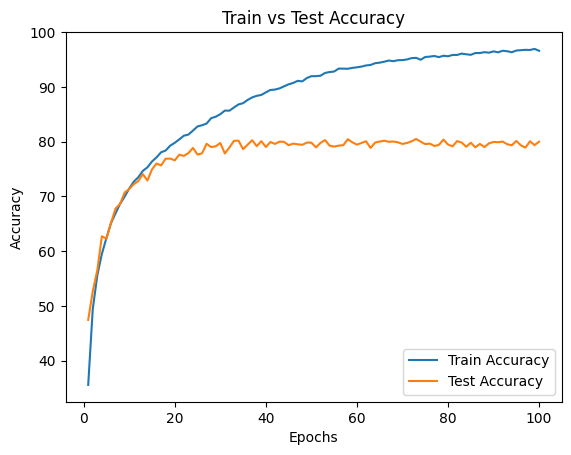

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
train_accs_gpu = train_accs.copy()
test_accs_gpu = test_accs.copy()
# train_accs_cpu = [acc.cpu().item() for acc in train_accs_gpu]
# test_accs_cpu = [acc.cpu().item() for acc in test_accs_gpu]
# print(train_accs)
# print(test_accs)
plt.plot(range(1, 101), train_accs_gpu, label='Train Accuracy')
plt.plot(range(1, 101), test_accs_gpu, label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc='lower right')

In [20]:
import time
import torch
import psutil
import os

# Example: Using a DataLoader for test data
def measure_metrics(model, dataloader, device):
    model.to(device)
    model.eval()

    total_inference_time = 0.0
    total_tokens = 0
    total_images = 0
    correct = 0
    total_memory_usage = 0.0
    total_cpu_usage = 0.0

    # Process object for CPU usage monitoring
    process = psutil.Process(os.getpid())

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Reset CUDA peak memory stats for this batch
            torch.cuda.reset_peak_memory_stats(device)

            # Capture CPU usage before inference (non-blocking, instantaneous)
            cpu_before = psutil.cpu_percent(interval=None)
            start_time = time.time()

            # Assume model outputs either logits or a tuple (logits, token_counts)
            outputs = model(images)
            if isinstance(outputs, tuple):
                logits, token_counts = outputs
            else:
                logits = outputs
                # For baseline VIT, token count can be set as a constant, e.g., number of patches
                token_counts = torch.full((images.size(0),), images.shape[1], dtype=torch.float32)

            end_time = time.time()
            cpu_after = psutil.cpu_percent(interval=None)
            inference_time = end_time - start_time
            total_inference_time += inference_time
            total_images += images.size(0)
            # Average CPU usage for this batch
            batch_cpu = (cpu_before + cpu_after) / 2
            total_cpu_usage += batch_cpu

            # Accuracy calculation
            predictions = logits.argmax(dim=1)
            correct += (predictions == labels).sum().item()

            # Record GPU memory usage (in bytes) for this batch
            memory_used = torch.cuda.max_memory_allocated(device)
            total_memory_usage += memory_used

            # Sum token counts (if model returns tensor, otherwise adjust accordingly)
            total_tokens += token_counts.sum().item() if torch.is_tensor(token_counts) else token_counts

    avg_inference_time = total_inference_time / total_images
    accuracy = correct / total_images * 100  # percentage
    avg_memory_usage_mb = (total_memory_usage / len(dataloader)) / (1024 ** 2)
    avg_cpu_usage = total_cpu_usage / len(dataloader)
    avg_tokens = total_tokens / total_images

    print("Average Inference Time per Image: {:.4f} seconds".format(avg_inference_time))
    print("Accuracy: {:.2f}%".format(accuracy))
    print("Average Memory Usage per Batch: {:.2f} MB".format(avg_memory_usage_mb))
    print("Average CPU Usage per Batch: {:.2f}%".format(avg_cpu_usage))
    print("Average Tokens per Image: {:.2f}".format(avg_tokens))


# Example FLOPs measurement using fvcore (install via pip install fvcore)
def measure_flops(model, input_tensor, device):
    from fvcore.nn import FlopCountAnalysis

    model.to(device)
    model.eval()
    flops = FlopCountAnalysis(model, input_tensor.to(device))
    # The total flops is given as a large integer; convert to TFLOPs if desired.
    total_flops = flops.total()
    tflops = total_flops / 1e12  # Convert FLOPs to TFLOPs
    print("Estimated FLOPs: {:.4f} TFLOPs".format(tflops))
    # Optionally, display a detailed table:
    print(flops.by_operator())

# Example usage:
if __name__ == "__main__":
    # Assume 'model' is your ViT or Dynamic ViT and 'test_loader' is your DataLoader for CIFAR-10.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    measure_metrics(model, testloader, device)
    
    # For FLOPs measurement, get one batch (or a single image) from the DataLoader
    input_tensor, _ = next(iter(testloader))
    measure_flops(model, input_tensor, device)


Average Inference Time per Image: 0.0000 seconds
Accuracy: 80.00%
Average Memory Usage per Batch: 90.96 MB
Average CPU Usage per Batch: 8.09%
Average Tokens per Image: 3.00


Unsupported operator aten::add_ encountered 1 time(s)
Unsupported operator aten::div encountered 6 time(s)
Unsupported operator aten::unflatten encountered 6 time(s)
Unsupported operator aten::mul encountered 30 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::add encountered 12 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::mean encountered 1 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
layers.0.F.attn.out_proj, layers.1.F.attn.out_proj, layers.2.F.attn.out_proj, layers.3.F.attn.out_proj, layers.4.F.attn.out_proj, layers.5.F.attn.out_proj


Estimated FLOPs: 0.0106 TFLOPs
Counter({'linear': 9664004096, 'bmm': 805306368, 'layer_norm': 63078400, 'conv': 50331648})
